# Alkım Ege Akarsu | 21901461 | CS 464 | HW2 | Q2

## Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

SEED = 0

np.random.seed(SEED)

## Functions

In [2]:
def standardize(X_train, X_val, X_test):
    """Standardize train, val, and test sets.

    Args:
        X_train (ndarray): Training set.
        X_val (ndarray): Validation set.
        X_test (ndarray): Test set.
    """
    # Get mean and std of training set
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    # Use mean and std on all sets to standardize
    X_train = (X_train - mean) / (std + 1e-7)
    X_val = (X_val - mean) / (std + 1e-7)
    X_test = (X_test - mean) / (std + 1e-7)
    
    return X_train, X_val, X_test


def sigmoid(x):
    """Sigmoid function.

    Args:
        x (ndarray): Input array.

    Returns:
        ndarray: Result of sigmoid function on input array.
    """
    return 1 / (1 + np.exp(-x))


def get_log_likelihood(X, y, w):
    """Get log-likelihood for logistic regression.

    Args:
        X (ndarray): Features
        y (ndarray): Labels
        w (ndarray): Weights

    Returns:
        ndarray: log-likelihood
    """
    X_w = np.dot(X, w)
    result = np.sum(y * X_w - np.log(1 + np.exp(X_w)))
    
    return result


def train_full_batch(X, y, num_steps, learning_rate):
    """Train a logistic regression model using full-batch gradient ascent on
    log-likelihood.

    Args:
        X (ndarray): Features
        y (ndarray): Labels
        num_steps (int): Number of steps to run gradient ascent.
        learning_rate (float): Gradient ascent learning rate.

    Returns:
        ndarray: Trained weights
    """
    # Initialize weights
    w = np.zeros(X.shape[1])
    # Gradient ascent for num_steps
    for _ in range(num_steps):
        pred = sigmoid(np.dot(X, w))
        err = y - pred
        grad = np.dot(X.T, err)
        w += learning_rate * grad
    
    return w


def train_mini_batch(X, y, num_steps, learning_rate, batch_size):
    """Train a logistic regression model using mini-batch gradient ascent on
    log-likelihood.

    Args:
        X (ndarray): Features
        y (ndarray): Labels
        num_steps (int): Number of steps to run gradient ascent.
        learning_rate (float): Gradient ascent learning rate.
        batch_size (int): Size of the mini-batch.

    Returns:
        ndarray: Trained weights
    """
    # Initialize weights
    w = np.zeros(X.shape[1])
    # Number of batches
    num_batches = int(X.shape[0] / batch_size)
    
    # Gradient ascent for num_steps
    for _ in range(num_steps):
        # Shuffle the data
        np.random.seed(SEED)
        random_indices = np.random.permutation(X.shape[0])
        X = X[random_indices]
        y = y[random_indices]
        # Loop over mini-batches
        for i in range(num_batches):
            # Get the mini-batch
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            y_batch = y[i * batch_size:(i + 1) * batch_size]
            # Gradient ascent
            pred = sigmoid(np.dot(X_batch, w))
            err = y_batch - pred
            grad = np.dot(X_batch.T, err)
            w += learning_rate * grad
    
    return w


def train_stochastic(X, y, num_steps, learning_rate):
    """Train a logistic regression model using stochastic gradient ascent on
    log-likelihood.

    Args:
        X (ndarray): Features
        y (ndarray): Labels
        num_steps (int): Number of steps to run gradient ascent.
        learning_rate (float): Gradient ascent learning rate.

    Returns:
        ndarray: Trained weights
    """
    # Initialize weights
    w = np.zeros(X.shape[1])
    # Get the number of samples
    num_samples = X.shape[0]
    # Stochastic gradient ascent for num_steps
    for _ in range(num_steps):
        # Shuffle the data
        np.random.seed(SEED)
        indices = np.random.permutation(num_samples)
        X = X[indices]
        y = y[indices]
        # Update weights using one sample at a time
        for i in range(num_samples):
            pred = sigmoid(np.dot(X[i], w))
            err = y[i] - pred
            grad = X[i] * err
            w += learning_rate * grad
    
    return w


def predict(X, w):
    """Predict using a logistic regression model.

    Args:
        X (ndarray): Features
        w (ndarray): Trained weights.

    Returns:
        ndarray: Predicted labels.
    """
    return np.uint8(sigmoid(np.dot(X, w)) > 0.5)


def get_confusion_matrix(y_true, y_pred):
    """Calculate confusion matrix for performance evaluation.

    Args:
        y_true (ndarray): Array of true labels.
        y_pred (ndarray): Array of predicted labels.

    Returns:
        ndarray: Confusion matrix
        TN FP
        FN TP
    """
    result = np.zeros((2, 2))

    for i in range(y_true.shape[0]):
        result[y_true[i]][y_pred[i]] += 1

    return result


def get_accuracy(y_true, y_pred):
    """Calculate accuracy for performance evaluation.

    Args:
        y_true (ndarray): Array of true labels.
        y_pred (ndarray): Array of predicted labels.

    Returns:
        double: Accuracy metric.
    """
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    
    return (TP + TN) / (TP + TN + FP + FN)


def get_precision(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return TP / (TP + FP)
    elif mode == "macro":
        return ((TP1 / (TP1 + FP1)) + (TP0 / (TP0 + FP0))) / 2
    elif mode == "micro":
        return (TP1 + TP0) / (TP1 + TP0 + FP1 + FP0)
    else:
        print("ERROR: Invalid mode")

def get_recall(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return TP / (TP + FN)
    elif mode == "macro":
        return ((TP1 / (TP1 + FN1)) + (TP0 / (TP0 + FN0))) / 2
    elif mode == "micro":
        return (TP1 + TP0) / (TP1 + TP0 + FN1 + FN0)
    else:
        print("ERROR: Invalid mode")


def get_negative_predictive_value(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return TN / (TN + FN)
    elif mode == "macro":
        return ((TN1 / (TN1 + FN1)) + (TN0 / (TN0 + FN0))) / 2
    elif mode == "micro":
        return (TN1 + TN0) / (TN1 + TN0 + FN1 + FN0)
    else:
        print("ERROR: Invalid mode")


def get_false_positive_rate(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return FP / (FP + TN)
    elif mode == "macro":
        return ((FP1 / (FP1 + TN1)) + (FP0 / (FP0 + TN0))) / 2
    elif mode == "micro":
        return (FP1 + FP0) / (FP1 + FP0 + TN1 + TN0)
    else:
        print("ERROR: Invalid mode")


def get_false_discovery_rate(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return FP / (FP + TP)
    elif mode == "macro":
        return ((FP1 / (FP1 + TP1)) + (FP0 / (FP0 + TP0))) / 2
    elif mode == "micro":
        return (FP1 + FP0) / (FP1 + FP0 + TP1 + TP0)
    else:
        print("ERROR: Invalid mode")


def get_f1_score(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return (2 * TP) / ((2 * TP) + FP + FN)
    elif mode == "macro":
        return (((2 * TP1) / ((2 * TP1) + FP1 + FN1)) + ((2 * TP0) / ((2 * TP0) + FP0 + FN0))) / 2
    elif mode == "micro":
        return ((2 * TP1) + (2 * TP0)) / (((2 * TP1) + FP1 + FN1) + ((2 * TP0) + FP0 + FN0))
    else:
        print("ERROR: Invalid mode")


def get_f2_score(y_true, y_pred, mode):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    TN1, FP1, FN1, TP1 = TN, FP, FN, TP
    TN0, FP0, FN0, TP0 = TP, FN, FP, TN
    if mode == "binary":
        return TP / (TP + (0.2 * FP) + (0.8 * FN))
    elif mode == "macro":
        return ((TP1 / (TP1 + (0.2 * FP1) + (0.8 * FN1))) + (TP0 / (TP0 + (0.2 * FP0) + (0.8 * FN0)))) / 2
    elif mode == "micro":
        return (TP1 + TP0) / ((TP1 + (0.2 * FP1) + (0.8 * FN1)) + (TP0 + (0.2 * FP0) + (0.8 * FN0)))
    else:
        print("ERROR: Invalid mode")


def get_evaluations(y_true, y_pred):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred).ravel()
    acc = get_accuracy(y_true, y_pred)
    precision_binary = get_precision(y_true, y_pred, "binary")
    precision_macro = get_precision(y_true, y_pred, "macro")
    precision_micro = get_precision(y_true, y_pred, "micro")
    recall_binary = get_recall(y_true, y_pred, "binary")
    recall_macro = get_recall(y_true, y_pred, "macro")
    recall_micro = get_recall(y_true, y_pred, "micro")
    npv_binary = get_negative_predictive_value(y_true, y_pred, "binary")
    npv_macro = get_negative_predictive_value(y_true, y_pred, "macro")
    npv_micro = get_negative_predictive_value(y_true, y_pred, "micro")
    fpr_binary = get_false_positive_rate(y_true, y_pred, "binary")
    fpr_macro = get_false_positive_rate(y_true, y_pred, "macro")
    fpr_micro = get_false_positive_rate(y_true, y_pred, "micro")
    fdr_binary = get_false_discovery_rate(y_true, y_pred, "binary")
    fdr_macro = get_false_discovery_rate(y_true, y_pred, "macro")
    fdr_micro = get_false_discovery_rate(y_true, y_pred, "micro")
    f1_binary = get_f1_score(y_true, y_pred, "binary")
    f1_macro = get_f1_score(y_true, y_pred, "macro")
    f1_micro = get_f1_score(y_true, y_pred, "micro")
    f2_binary = get_f2_score(y_true, y_pred, "binary")
    f2_macro = get_f2_score(y_true, y_pred, "macro")
    f2_micro = get_f2_score(y_true, y_pred, "micro")
    # Print evaluations
    print(f"Confusion matrix: TN, FP, TP, FN: {TN}, {FP}, {TP}, {FN}")
    print(f"Accuracy: {acc}")
    print(f"Precision (binary): {precision_binary}")
    print(f"Precision (macro): {precision_macro}")
    print(f"Precision (micro): {precision_micro}")
    print(f"Recall (binary): {recall_binary}")
    print(f"Recall (macro): {recall_macro}")
    print(f"Recall (micro): {recall_micro}")
    print(f"NPV (binary): {npv_binary}")
    print(f"NPV (macro): {npv_macro}")
    print(f"NPV (micro): {npv_micro}")
    print(f"FPR (binary): {fpr_binary}")
    print(f"FPR (macro): {fpr_macro}")
    print(f"FPR (micro): {fpr_micro}")
    print(f"FDR (binary): {fdr_binary}")
    print(f"FDR (macro): {fdr_macro}")
    print(f"FDR (micro): {fdr_micro}")
    print(f"F1 (binary): {f1_binary}")
    print(f"F1 (macro): {f1_macro}")
    print(f"F1 (micro): {f1_micro}")
    print(f"F2 (binary): {f2_binary}")
    print(f"F2 (macro): {f2_macro}")
    print(f"F2 (micro): {f2_micro}")

## Logistic Regression

In [3]:
# Get dataset directories
train_path = Path().resolve().joinpath("datasets", "Spambase_train.csv")
val_path = Path().resolve().joinpath("datasets", "Spambase_val.csv")
test_path = Path().resolve().joinpath("datasets", "Spambase_test.csv")
# Load datasets
train = pd.read_csv(train_path, sep="\t")
val = pd.read_csv(val_path, sep="\t")
test = pd.read_csv(test_path, sep="\t")
# Get X and y values
y_train, y_val, y_test = train["Class"], val["Class"], test["Class"]
X_train, X_val, X_test = train.drop(columns="Class"), val.drop(columns="Class"), test.drop(columns="Class")
# Convert all DataFrames to numpy arrays
y_train, y_val, y_test = y_train.to_numpy(), y_val.to_numpy(), y_test.to_numpy()
X_train, X_val, X_test = X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy()
# Standardize X values
X_train, X_val, X_test = standardize(X_train, X_val, X_test)

### 2.1

Confusion matrix: TN, FP, TP, FN: 45.0, 5.0, 48.0, 2.0
Accuracy: 0.93
Precision (binary): 0.9056603773584906
Precision (macro): 0.9315535929345644
Precision (micro): 0.93
Recall (binary): 0.96
Recall (macro): 0.9299999999999999
Recall (micro): 0.93
NPV (binary): 0.9574468085106383
NPV (macro): 0.9315535929345644
NPV (micro): 0.93
FPR (binary): 0.1
FPR (macro): 0.07
FPR (micro): 0.07
FDR (binary): 0.09433962264150944
FDR (macro): 0.06844640706543557
FDR (micro): 0.07
F1 (binary): 0.9320388349514563
F1 (macro): 0.9299369432489241
F1 (micro): 0.93
F2 (binary): 0.9486166007905138
F2 (macro): 0.9297738874397914
F2 (micro): 0.93


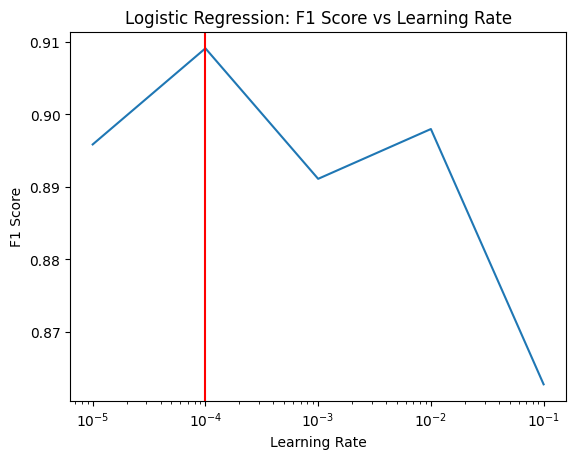

In [4]:
# Train and predict with logistic regression models using different learning rates
trained_weights = {}
predictions = {}
for lr in np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1]):
    trained_weights[lr] = train_full_batch(X_train, y_train, num_steps=1000, learning_rate=lr)
    predictions[lr] = predict(X_val, trained_weights[lr])
# Get F1 scores for each learning rate
f1_scores = {lr: get_f1_score(y_val, predictions[lr], "binary") for lr in predictions}
# Get best learning rate
best_lr = max(f1_scores, key=f1_scores.get)
# Plot F1 scores
plt.figure()
plt.title("Logistic Regression: F1 Score vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.xscale("log")
plt.plot(list(f1_scores.keys()), list(f1_scores.values()))
plt.axvline(x=best_lr, color="red")

# Get best weights
best_weights = trained_weights[best_lr]
# Predict test set
test_pred = predict(X_test, best_weights)
# Get evaluations
get_evaluations(y_test, test_pred)

### 2.2

In [5]:
# Train mini-batch
mini_batch_weights = train_mini_batch(X_train, y_train, 1000, 7.601177617955322e-05, 32)
# Predict test set
test_pred = predict(X_test, mini_batch_weights)
# Get evaluations
get_evaluations(y_test, test_pred)

# Train stochastic
stochastic_weights = train_stochastic(X_train, y_train, 1000, 7.601177617955322e-05)
# Predict test set
test_pred = predict(X_test, stochastic_weights)
# Get evaluations
get_evaluations(y_test, test_pred)

Confusion matrix: TN, FP, TP, FN: 45.0, 5.0, 48.0, 2.0
Accuracy: 0.93
Precision (binary): 0.9056603773584906
Precision (macro): 0.9315535929345644
Precision (micro): 0.93
Recall (binary): 0.96
Recall (macro): 0.9299999999999999
Recall (micro): 0.93
NPV (binary): 0.9574468085106383
NPV (macro): 0.9315535929345644
NPV (micro): 0.93
FPR (binary): 0.1
FPR (macro): 0.07
FPR (micro): 0.07
FDR (binary): 0.09433962264150944
FDR (macro): 0.06844640706543557
FDR (micro): 0.07
F1 (binary): 0.9320388349514563
F1 (macro): 0.9299369432489241
F1 (micro): 0.93
F2 (binary): 0.9486166007905138
F2 (macro): 0.9297738874397914
F2 (micro): 0.93
Confusion matrix: TN, FP, TP, FN: 45.0, 5.0, 48.0, 2.0
Accuracy: 0.93
Precision (binary): 0.9056603773584906
Precision (macro): 0.9315535929345644
Precision (micro): 0.93
Recall (binary): 0.96
Recall (macro): 0.9299999999999999
Recall (micro): 0.93
NPV (binary): 0.9574468085106383
NPV (macro): 0.9315535929345644
NPV (micro): 0.93
FPR (binary): 0.1
FPR (macro): 0.07
F